## 1. Comparing XGBoost vs. Logistic Regression (2019–2023)

In our previous notebook, we built a baseline model using **logistic regression** to predict diabetes risk from BRFSS data. Logistic regression is fast, interpretable, and a common starting point — but it struggled to detect diabetes cases accurately due to class imbalance and limited model flexibility.

In this notebook, we begin by applying **XGBoost** to the **same 2019–2023 dataset**, allowing for a **direct comparison**. Unlike logistic regression, XGBoost is a gradient-boosted decision tree model that can:

- Capture non-linear relationships
- Handle feature interactions automatically
- Deal more effectively with imbalanced classes (e.g., with `scale_pos_weight`)

By comparing these two models head-to-head, we can assess whether a more sophisticated algorithm offers meaningful performance gains — particularly in **recall for the minority class (diabetes cases)**.

Once we’ve made this comparison, we’ll switch to a **cleaner 2022–2023 subset** for further feature engineering, hyperparameter tuning, and interpretability analysis.

Let’s begin by loading the same data and training both models.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import time
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
)
from sklearn.model_selection import train_test_split

# Custom project imports (same as Notebook 00)
from brfss_diabetes.io import load_all_years
from brfss_diabetes.preprocessing import prepare_common_features

In [2]:
# Globals
SEED = 22
start_time = time.time()

# Set paths
image_dir = Path("..") / "images"
reports_dir = Path("..") / "reports"
data_dir = Path("..") / "data/cleaned"

# Ensure that output directories exist
os.makedirs(image_dir, exist_ok=True)
os.makedirs(reports_dir, exist_ok=True)

### 1.1 Load and Prepare Data

While the BRFSS dataset contains many features, not all are consistently available or complete across the 2019–2023 survey years. For modeling purposes, we restrict our focus to a core set of features that:

- Appear in all five years,
- Have acceptable levels of missingness,
- Are relevant for modeling diabetes risk.

The selected `common_features` below meet these criteria and will be used in subsequent modeling steps.

In [3]:
# Use only features common to all years
common_features = ["age", "sex", "educa", "bmi", "bmi_cat", "smoke_100", "exercise_any"]

# Load and prepare data
years = [2019, 2020, 2021, 2022, 2023]
df_all = load_all_years(years)

[Local] Loading from: ../data/cleaned/brfss_cleaned_2019.csv
[Local] Loading from: ../data/cleaned/brfss_cleaned_2020.csv
[Local] Loading from: ../data/cleaned/brfss_cleaned_2021.csv
[Local] Loading from: ../data/cleaned/brfss_cleaned_2022.csv
[Local] Loading from: ../data/cleaned/brfss_cleaned_2023.csv


In [4]:
df_common = prepare_common_features(df_all, common_features)

print(df_common.shape)
print(df_common.head())
print("\nAny NaNs in X?", df_common.drop(columns=["diabetes"]).isna().any().any())

(1842899, 12)
    age    bmi  smoke_100  exercise_any  diabetes  sex_Male  educa_HS or GED  \
0  85.0  28.17          1             0         0     False            False   
1  72.0  18.54          0             1         0     False            False   
2  67.0  31.62          0             1         1     False            False   
4  85.0  21.48          1             0         0     False            False   
6  72.0  32.98          1             1         1      True            False   

   educa_Less than HS  educa_Some college  bmi_cat_Obese  bmi_cat_Overweight  \
0                True               False          False                True   
1               False                True          False               False   
2               False               False           True               False   
4               False                True          False               False   
6               False               False           True               False   

   bmi_cat_Underweight  

### 1.2 Train/Test Split

In [5]:
# Split features and target
X = df_common.drop(columns=["diabetes"])
y = df_common["diabetes"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

### 1.3 Train and Evaluate Logistic Regression

Before comparing against XGBoost, we replicate the logistic regression pipeline from Notebook 00 — including **SMOTE**, which helps handle class imbalance in the training data.

#### 1.3.1 Why SMOTE? Addressing Class Imbalance

In this dataset, only about **1 in 7** individuals reported being told they had diabetes — a clear case of **class imbalance**. Models trained on imbalanced data often become biased toward predicting the majority class (“No diabetes”), which can result in:

- High overall accuracy,
- But **poor recall** for the minority class (“Diabetes”).

To mitigate this, we apply **SMOTE** (Synthetic Minority Over-sampling Technique) to the **training set only**. SMOTE creates **synthetic samples** of the minority class by interpolating between existing cases, helping the model learn decision boundaries that better reflect both classes.

This ensures a fair comparison between logistic regression and XGBoost under the same conditions — allowing us to isolate the benefits of the more complex model architecture.

We now apply SMOTE *after* splitting to avoid any data leakage.

In [6]:
# Print class distribution before resampling
print(f"Before SMOTE y_train counts:\n{y_train.value_counts()}\n")

# Apply SMOTE to training data only (to avoid data leakage)
smote = SMOTE(random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train logistic regression with balanced class weights
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_resampled, y_resampled)

# Predict on original (imbalanced) test set
y_pred = model.predict(X_test)

# Print class distribution after SMOTE
print(f"After SMOTE y_resampled counts:\n{y_resampled.value_counts()}")

Before SMOTE y_train counts:
diabetes
0    1261433
1     212886
Name: count, dtype: int64

After SMOTE y_resampled counts:
diabetes
0    1261433
1    1261433
Name: count, dtype: int64


### 1.4 Baseline: Logistic Regression Performance (Summary)

To fairly compare XGBoost against our earlier baseline, we first replicate the logistic regression model on the same 2019–2023 data.

This model was trained using SMOTE to handle class imbalance (as explained in Notebook 00), and evaluated under multiple decision thresholds:
- **Balanced (threshold ≈ 0.68)**
- **F2 score optimized (threshold ≈ 0.41)** – favors **recall**
- **F0.5 score optimized (threshold ≈ 0.69)** – favors **precision**

We summarize logistic regression’s classification performance below as a reference point before training XGBoost.

In [7]:
# Predict probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate precision-recall pairs for all thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find threshold that maximizes F2 score (recall emphasis)
beta = 2 
f2_scores = (1 + beta**2) * (precision[:-1] * recall[:-1]) / (beta**2 * precision[:-1] + recall[:-1] + 1e-8)
f2_idx = np.argmax(f2_scores)
f2_threshold = thresholds[f2_idx]
print(f"Best F2 threshold: {f2_threshold:.5f}")

Best F2 threshold: 0.40556


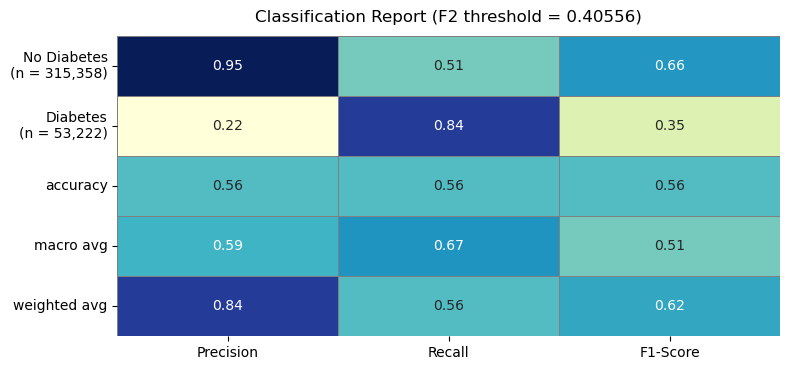

In [8]:
# Define threshold and predictions first
threshold_val = f2_threshold
y_pred_f2 = (y_probs >= threshold_val).astype(int)

report_dict = classification_report(y_test, y_pred_f2, output_dict=True)
df = pd.DataFrame(report_dict).transpose()

# Format row labels with support counts
df.rename(index={"0": "No Diabetes", "1": "Diabetes"}, inplace=True)
supports = df.loc[["No Diabetes", "Diabetes"], "support"].dropna().astype(int).map("{:,}".format)
row_labels = {
    label: f"{label}\n(n = {supports[label]})"
    for label in ["No Diabetes", "Diabetes"]
}
row_labels["accuracy"] = "accuracy"
row_labels["macro avg"] = "macro avg"
row_labels["weighted avg"] = "weighted avg"

# Select rows and metrics
rows_to_plot = ["No Diabetes", "Diabetes", "accuracy", "macro avg", "weighted avg"]
metrics = df.loc[rows_to_plot, ["precision", "recall", "f1-score"]].round(2)
row_label_list = [row_labels[r] for r in rows_to_plot]

# Plot
fig, ax = plt.subplots(figsize=(8, 3.8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
            linewidths=0.5, linecolor="gray", ax=ax,
            xticklabels=["Precision", "Recall", "F1-Score"],
            yticklabels=row_label_list)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title(f"Classification Report (F2 threshold = {threshold_val:.5f})", fontsize=12, pad=10)
plt.tight_layout()
plt.savefig(image_dir / "01_classification_report_f2.png", dpi=300)
plt.show()

This heatmap shows model performance using the threshold that **maximizes the F2 score**, which gives **extra weight to recall**:

- The model correctly identifies **84% of actual diabetes cases** (recall), a major gain compared to the ~35% at the balanced threshold.
- However, **precision drops to 22%** — most positive predictions are false alarms.
- For the **No Diabetes** class, precision remains high at **95%**, but recall falls to 51% — many are incorrectly flagged as diabetic.
- **Overall accuracy falls to 56%**, but this is expected: we’ve sacrificed precision and accuracy in order to **catch more true positives**.

This setting is ideal for **screening scenarios** where **missing real cases is riskier** than issuing false positives — for example, early-stage population health interventions.

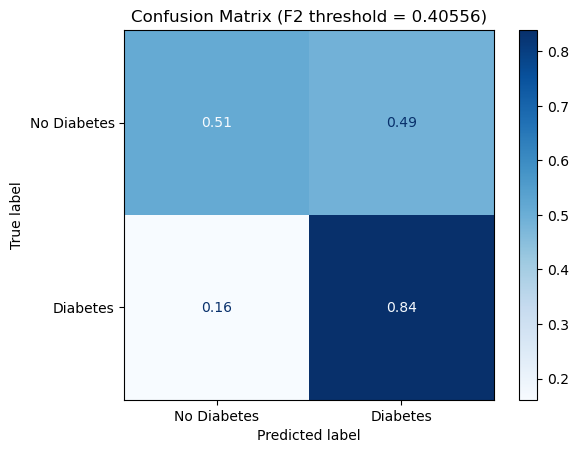

In [9]:
# Confusion matrix at F2 threshold
cm = confusion_matrix(y_test, y_pred_f2, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (F2 threshold = {threshold_val:.5f})")
plt.grid(False)
plt.savefig(image_dir / "01_confusion_matrix_f2.png", dpi=300)
plt.show()

This confusion matrix shows the model’s performance using the **F2-optimized threshold**, which emphasizes **recall** — prioritizing the identification of as many true diabetes cases as possible.

- Of all actual diabetes cases (bottom row), **84% were correctly identified** (true positives), while **16% were missed** (false negatives).
- Among people without diabetes (top row), the model incorrectly flagged **49% as diabetic** (false positives), reflecting the trade-off in precision.

This threshold may be appropriate for **screening scenarios**, where **missing true cases** is more costly than generating some **false alarms**.

### 1.5 Summary: Logistic Regression Performance (2019–2023)

Below is the classification performance of our logistic regression model under different decision thresholds. These highlight the tradeoffs between **precision** and **recall**, especially for the minority class (diabetes):

| Strategy             | Precision (Diabetes) | Recall (Diabetes) | Use Case                                        |
|----------------------|----------------------|--------------------|-------------------------------------------------|
| **Balanced (Precision = Recall)** | ~0.35                | ~0.35              | Equal weight to false positives/negatives       |
| **Recall-Weighted (F2) **     | ~0.22                | **~0.84**          | Emphasize **recall** — early screening          |
| **Precision-Weighted (F0.5)**   | **~0.35**            | ~0.34              | Emphasize **precision** — expensive follow-up   |

We will now apply **XGBoost** to this same dataset to evaluate whether a tree-based model can achieve better recall while maintaining usable precision.

### Confusion Matrix Summary (Logistic Regression)

| Threshold Type         |   TN (No Diabetes) |   FP (No Diabetes) |   FN (Diabetes) |   TP (Diabetes) |   Recall (Diabetes) |   Precision (Diabetes) |
|------------------------|--------------------|---------------------|------------------|------------------|----------------------|-------------------------|
| Balanced (Precision = Recall)      |               0.89 |                0.11 |             0.65 |             0.35 |                 0.35 |                   0.35 |
| Recall-Weighted (F2)   |               0.51 |                0.49 |             0.16 |             0.84 |                 0.84 |                   0.22 |
| Precision-Weighted (F0.5) |           0.89 |                0.11 |             0.66 |             0.34 |                 0.34 |                   0.89 |


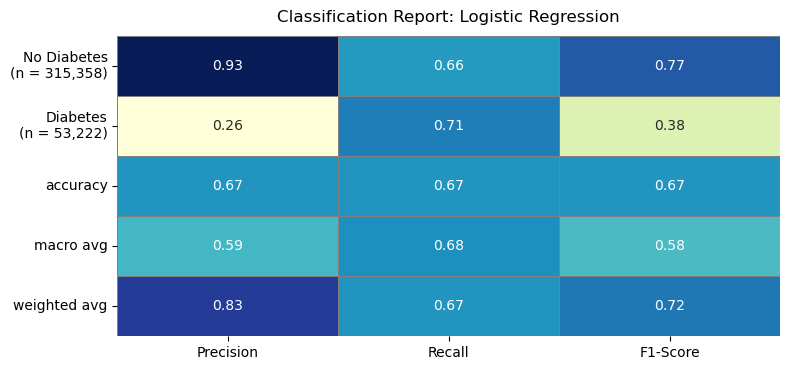

In [10]:
# Predict class probabilities and labels
y_probs_lr = model.predict_proba(X_test)[:, 1]
y_pred_lr = model.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred_lr, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(2)

# Rename labels
df_report.rename(index={"0": "No Diabetes", "1": "Diabetes"}, inplace=True)

# Display support counts
supports = df_report.loc[["No Diabetes", "Diabetes"], "support"].astype(int).map("{:,}".format)
row_labels = {
    label: f"{label}\n(n = {supports[label]})"
    for label in ["No Diabetes", "Diabetes"]
}
row_labels["accuracy"] = "accuracy"
row_labels["macro avg"] = "macro avg"
row_labels["weighted avg"] = "weighted avg"

# Select key metrics
rows = ["No Diabetes", "Diabetes", "accuracy", "macro avg", "weighted avg"]
metrics = df_report.loc[rows, ["precision", "recall", "f1-score"]]

# Heatmap
fig, ax = plt.subplots(figsize=(8, 3.8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
            linewidths=0.5, linecolor="gray", ax=ax,
            xticklabels=["Precision", "Recall", "F1-Score"],
            yticklabels=[row_labels[r] for r in rows])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("Classification Report: Logistic Regression", fontsize=12, pad=10)
plt.tight_layout()
plt.savefig(image_dir / "classification_report_logistic.png", dpi=300)
plt.show()


### 1.4 Train and Evaluate XGBoost

### 1.5 Visual Comparison of Results

## Quick EDA

In [11]:
# # Check target class balance
# print(df_all["diabetes"].value_counts())
# print(df_all["diabetes"].value_counts(normalize=True))

In [12]:
# # Count by year
# print(df_all.groupby("year")["diabetes"].value_counts(normalize=True))

In [13]:
# sns.countplot(data=df_all, x="year", hue="diabetes")
# plt.title("Diabetes prevalence by year")
# plt.show()

## Baseline model

### Preprocessing

In [14]:
df_model = df_all.copy()

# Features and target
features = [
    "year", "age", "sex", "educa", "bmi", "bmi_cat", "drink_any", "snap_used",
    "food_insecurity", "smoke_100", "exercise_any"
]

target = "diabetes"

df_model = df_model[features + [target]].copy()


### Convert binary and categorical vars
binary_cols = ["smoke_100", "exercise_any", "diabetes", "drink_any", "snap_used"]
for col in binary_cols:
    df_model[col] = df_model[col].astype(str).str.strip().str.replace('"', '').map({"Yes": 1, "No": 0})

In [15]:
### Convert categorical strings to dummy vars
df_model = pd.get_dummies(df_model, columns=["sex", "educa", "bmi_cat", 
                                             "food_insecurity"], drop_first=True)

print(df_model.columns.tolist())
print("Any NaNs in X?", df_model.drop(columns=["diabetes"]).isna().any().any())
df_model.head()

['year', 'age', 'bmi', 'drink_any', 'snap_used', 'smoke_100', 'exercise_any', 'diabetes', 'sex_Male', 'educa_HS or GED', 'educa_Less than HS', 'educa_Some college', 'bmi_cat_Obese', 'bmi_cat_Overweight', 'bmi_cat_Underweight', 'food_insecurity_Never', 'food_insecurity_Rarely', 'food_insecurity_Sometimes', 'food_insecurity_Usually']
Any NaNs in X? True


,year,age,bmi,drink_any,snap_used,smoke_100,exercise_any,diabetes,sex_Male,educa_HS or GED,educa_Less than HS,educa_Some college,bmi_cat_Obese,bmi_cat_Overweight,bmi_cat_Underweight,food_insecurity_Never,food_insecurity_Rarely,food_insecurity_Sometimes,food_insecurity_Usually
0,2019,85.0,28.17,0.0,NaN,1.0,0.0,0,False,False,True,False,False,True,False,False,False,False,False
1,2019,72.0,18.54,0.0,NaN,0.0,1.0,0,False,False,False,True,False,False,False,False,False,False,False
2,2019,67.0,31.62,0.0,NaN,0.0,1.0,1,False,False,False,False,True,False,False,False,False,False,False
3,2019,85.0,20.30,NaN,NaN,NaN,NaN,0,False,False,False,True,False,False,False,False,False,False,False
4,2019,85.0,21.48,0.0,NaN,1.0,0.0,0,False,False,False,True,False,False,False,False,False,False,False


In [16]:
print("Before split:", df_model.shape)

features = [f for f in features if f in df_model.columns]
# Drop rows with missing values in selected features or target
df_model = df_model.dropna(subset=features + [target])

print("After dropping NA:", df_model.shape)

Before split: (2132659, 19)
After dropping NA: (458406, 19)


In [17]:
# Split features and target
X = df_model.drop(columns=["diabetes"])
y = df_model["diabetes"]

## Train/Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
print(X_train.shape, X_test.shape)

(366724, 18) (91682, 18)


## Baseline Model

In [19]:
neg, pos = np.bincount(y_train)
print(f"Negative: {neg}, positive: {pos}")
scale = neg / pos
print(f"Negative: {neg}, positive: {pos}, scale: {scale:.2f}")

model = xgb.XGBClassifier(
    # use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=SEED
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"y_test shape: {y_test.shape}")
print(f"y_pred shape: {y_pred.shape}")

Negative: 312083, positive: 54641
Negative: 312083, positive: 54641, scale: 5.71
y_test shape: (91682,)
y_pred shape: (91682,)


## Evaluation

In [20]:
print("\nClassification Report(Baseline XGBoost):")
print(classification_report(y_test, y_pred, digits=3))


Classification Report(Baseline XGBoost):
              precision    recall  f1-score   support

           0      0.935     0.658     0.772     78021
           1      0.275     0.740     0.401     13661

    accuracy                          0.670     91682
   macro avg      0.605     0.699     0.587     91682
weighted avg      0.837     0.670     0.717     91682



### Visualizations

In [21]:
# y_true = df_model["diabetes"]
# y_probs = model.predict_proba(X)[:, 1]

# # ROC Curve
# fpr, tpr, thresholds_roc = roc_curve(y_true, y_probs)
# roc_auc = roc_auc_score(y_true, y_probs)

# plt.figure()
# plt.plot(fpr, tpr, label=f"AUC + {roc_auc:.2f}")
# plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate (Recall)")
# plt.title("ROC Curve")
# plt.legend()
# plt.grid(True)
# plt.show()

In [22]:
print(classification_report(y_test, y_pred, digits=3))
print(f"y_test shape: {y_test.shape}")
print(f"y_pred shape: {y_pred.shape}")

              precision    recall  f1-score   support

           0      0.935     0.658     0.772     78021
           1      0.275     0.740     0.401     13661

    accuracy                          0.670     91682
   macro avg      0.605     0.699     0.587     91682
weighted avg      0.837     0.670     0.717     91682

y_test shape: (91682,)
y_pred shape: (91682,)


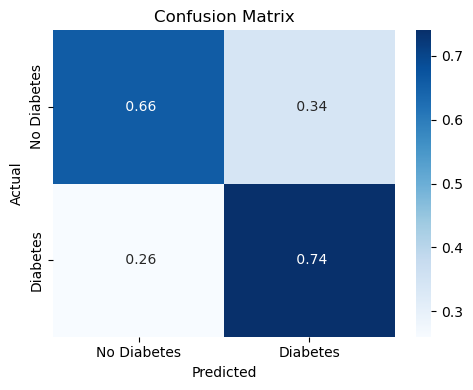

In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt=" .2f", cmap="Blues",
            xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"])

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap="Blues", values_format=".2f")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.grid(False)
plt.savefig("../reports/xgboost_confusion_matrix.png")
plt.show()

y_probs shape: (91682,)
y_test shape: (91682,)


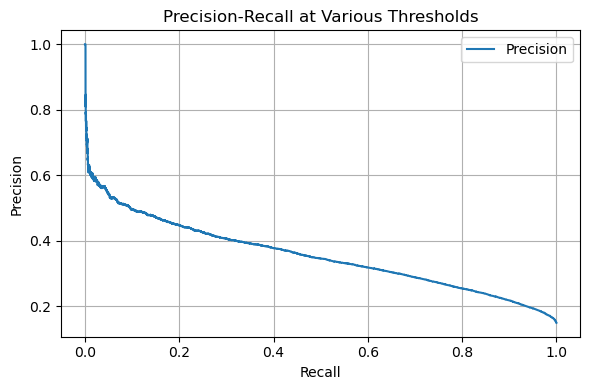

In [24]:
# Get predicted probabilities for the positve class (diabetes)
y_probs = model.predict_proba(X_test)[:, 1]

print(f"y_probs shape: {y_probs.shape}")
print(f"y_test shape: {y_test.shape}")

# # Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# avg_precision = average_precision_score(y_true, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall at Various Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## End

In [25]:
time_spent = (time.time() - start_time) / 60 

print(f"Notebook time: {time_spent:.2f} minutes")

Notebook time: 1.41 minutes
